In [13]:
import pandas as pd
import nltk
import re
import json
from pathlib import Path
from typing import Dict, List, Optional
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Imports pieces of the Kaggle dataset 
# TODO: Replace it using the J-Archive to make a random sample. Maybe find which seasons are in each set of five years, then use random number generator to choose seasons/episodes/columns of the board?
single_jeopardy_df = pd.read_csv('./data/single_jeopardy.csv', usecols=['air_date', 'round', 'category', 'value', 'question', 'answer'])
double_jeopardy_df = pd.read_csv('./data/double_jeopardy.csv', usecols=['air_date', 'round', 'category', 'value', 'question', 'answer'])
final_jeopardy_df = pd.read_csv('./data/final_jeopardy.csv', usecols=['air_date', 'round', 'category', 'value', 'question', 'answer'])

In [3]:
single_jeopardy_df['air_date'] = pd.to_datetime(single_jeopardy_df['air_date'])
double_jeopardy_df['air_date'] = pd.to_datetime(double_jeopardy_df['air_date'])
final_jeopardy_df['air_date'] = pd.to_datetime(final_jeopardy_df['air_date'])

single_jeopardy_df.sort_values(by='air_date', inplace=True)
double_jeopardy_df.sort_values(by='air_date', inplace=True)
final_jeopardy_df.sort_values(by='air_date', inplace=True)
print(single_jeopardy_df.head(5))
print(double_jeopardy_df.head(5))
print(final_jeopardy_df.head(5))

features_df = single_jeopardy_df.copy(deep=True)

/var/folders/pn/fvrfx8z96tz23h3t5j3qsqrh0000gn/T/ipykernel_4859/4138786712.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  single_jeopardy_df['air_date'] = pd.to_datetime(single_jeopardy_df['air_date'])
/var/folders/pn/fvrfx8z96tz23h3t5j3qsqrh0000gn/T/ipykernel_4859/4138786712.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  double_jeopardy_df['air_date'] = pd.to_datetime(double_jeopardy_df['air_date'])
/var/folders/pn/fvrfx8z96tz23h3t5j3qsqrh0000gn/T/ipykernel_4859/4138786712.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  final_jeopardy_df['air_date'] = pd.to_d

        air_date      round         category  value  \
41853 1984-09-10  Jeopardy!   ACTORS & ROLES  500.0   
41852 1984-09-10  Jeopardy!          ANIMALS  500.0   
41851 1984-09-10  Jeopardy!   LAKES & RIVERS  500.0   
41850 1984-09-10  Jeopardy!   ACTORS & ROLES  400.0   
41849 1984-09-10  Jeopardy!  FOREIGN CUISINE  400.0   

                                                question                answer  
41853  Sam Shepard played this barrier breaker in "Th...  Colonel Chuck Yeager  
41852  If this species of hybrid's parents were rever...                a mule  
41851  World's largest lake, nearly 5 times as big as...       the Caspian Sea  
41850  The blonde preferred in the film "Gentlemen Pr...        Marilyn Monroe  
41849  French for a toothsome cut of beef served to a...         Ch̢teaubriand  
        air_date             round            category  value  \
41293 1984-09-10  Double Jeopardy!            '50'S TV  800.0   
41291 1984-09-10  Double Jeopardy!      4-LETTER WORD

In [4]:
# Download nltk English stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leahhersh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
def get_pos_tag(tag):
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:          
        return 'n' 


def preprocess_category(category):
    
    # Turn category into an untagged, alphanumeric, lowercase string
    category = re.sub(re.compile('<.*?>'), '', category) 
    category = re.sub('[^A-Za-z0-9]+', ' ', category) 
    category = category.lower()

    # Tokenize categorie and remove stopwords
    stop_words = stopwords.words('english') 
    tokens = word_tokenize(category)
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize tokens
    pos_tagged_category = nltk.pos_tag(tokens) 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_pos_tag(tag)) for word, tag in pos_tagged_category]

    # Return category as processed tokens
    return tokens


# Pre-process categorys, and store them tokenized in a separate column
features_df['category_key_words'] = features_df['category'].apply(preprocess_category)
print(features_df['category_key_words'].head(10))
print(features_df["category_key_words"].tail(10))

41853         [actor, role]
41852              [animal]
41851         [lake, river]
41850         [actor, role]
41849    [foreign, cuisine]
41848              [animal]
41847           [invention]
41845         [actor, role]
41844    [foreign, cuisine]
41843              [animal]
Name: category_key_words, dtype: object
52443    [less, know, scientist]
52442           [stupid, answer]
52441             [child, actor]
52456      [truth, lie, therein]
52457              [visit, city]
52458                     [pant]
52459             [child, actor]
52460           [stupid, answer]
52440                     [pant]
52448           [stupid, answer]
Name: category_key_words, dtype: object


In [6]:
# Find and remove "stopwords" (extremely common words excluded in the nltk list), then return the categorysuntokenized ahead of vectorization:

# Finds words that appear suspiciously often in a df column
def find_leftover_stopwords(df, col_title):
    threshold = 0.25

    word_counts = Counter(word for category in df[col_title] for word in category)
    threshold_count = len(df[col_title]) * threshold
    leftover_stopwords = [word for word, count in word_counts.items() if count >= threshold_count]

    return leftover_stopwords

# Removes stopwords found by frequency and single-character words
def remove_words_and_untokenize(lst, items_to_remove):
    filtered_list = [item for item in lst if item not in items_to_remove]
    filtered_list = [item for item in lst if len(item) > 1]
    return " ".join(filtered_list)


# Remove the custom stopwords founds and convert categorys back to strings
custom_stopwords = find_leftover_stopwords(features_df, "category_key_words")

In [ ]:
# Add jeopardy-specific stopwords
features_df["category_key_words"] = features_df["category_key_words"].apply(lambda x: remove_words_and_untokenize(x, custom_stopwords))
print(features_df["category_key_words"].head(10))

41853         actor role
41852             animal
41851         lake river
41850         actor role
41849    foreign cuisine
41848             animal
41847          invention
41845         actor role
41844    foreign cuisine
41843             animal
Name: category_key_words, dtype: object


In [8]:
def find_frequencies(df, col_title):
    
    # Join all categories into one string
    joined_categories = ' '.join(df[col_title]).split()

    # Iterate over strings and count the occurences of each word
    category_word_freqs = Counter(joined_categories)

    # Store words and frequencies in seperate dataFrames
    category_word_freq_df = pd.DataFrame(list(category_word_freqs.items()), columns=['Word:', 'Frequency:'])

    # Order the categories by frequency instead of index and remove all indexes 
    category_word_freq_df = category_word_freq_df.sort_values(by='Frequency:', ascending=False)
    category_word_freq_df.reset_index(drop=True, inplace=True)

    return category_word_freq_df


# Find and print the n most common words used in categories and their frequency
top_n = 20
category_word_freq_df = find_frequencies(features_df, "category_key_words")
print('\nTop {0} words used in categories and their frequencies:\n'.format(top_n))
print(category_word_freq_df.head(top_n).to_string(index=False))


Top 20 words used in categories and their frequencies:

   Word:  Frequency:
    word        2630
    name        2179
      tv        1770
   world        1701
   state        1662
 history        1576
   movie        1535
    time        1483
  letter        1471
american        1208
   sport        1203
    food        1122
    city        1028
   rhyme        1010
    song         983
   first         906
     new         849
  animal         841
 science         839
   music         821


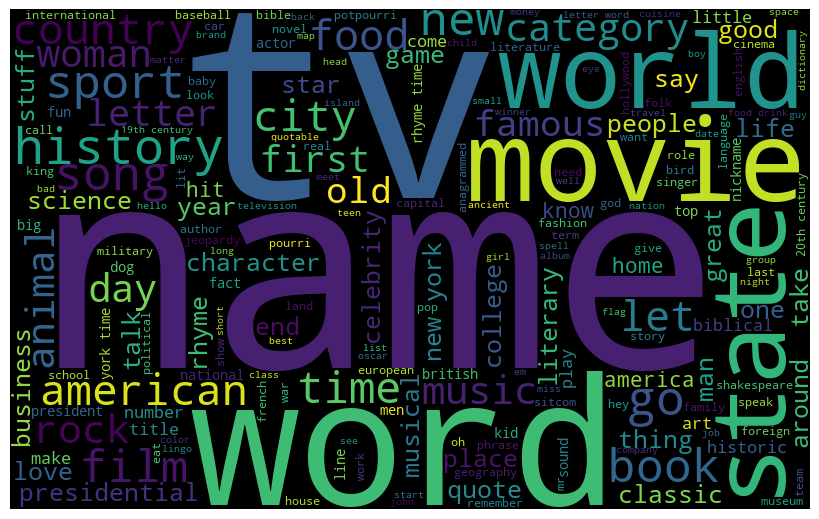

In [9]:
def display_word_clouds(df, col_title):
    word_list = df[col_title].unique().tolist()

    words = ' '.join(word_list)
    wordcloud =  WordCloud(width=800, height = 500).generate(words)

    plt.figure(figsize=(8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()


# Generate word cloud for categorys
display_word_clouds(features_df, "category_key_words")

In [10]:
# Select all the questions that correspond to each of the top_n categories

# Build a combined DataFrame across all rounds
all_questions_df = pd.concat([single_jeopardy_df, double_jeopardy_df, final_jeopardy_df], ignore_index=True)

# Determine the top_n categories by frequency
top_categories = (all_questions_df['category']
                  .astype(str)
                  .str.strip()
                  .value_counts()
                  .head(top_n)
                  .index
                  .tolist())

def find_questions_for_category(df, category):
    tokens = preprocess_category(category)
    if not tokens:
        cleaned = re.sub('[^A-Za-z0-9]+', ' ', str(category)).strip().lower()
        tokens = cleaned.split()
    if not tokens:
        return []
    question_lower = df['question'].astype(str).str.lower()
    mask = None
    for token in tokens:
        pattern = r'\b{0}\b'.format(re.escape(token))
        token_mask = question_lower.str.contains(pattern, na=False)
        mask = token_mask if mask is None else (mask | token_mask)
    return df.loc[mask, 'question'].dropna().head(100).tolist()

question_bank = {category: pd.Series(find_questions_for_category(all_questions_df, category))
                 for category in top_categories}

question_bank_df = pd.DataFrame(question_bank)
question_bank_df


,BEFORE & AFTER,SCIENCE,LITERATURE,AMERICAN HISTORY,POTPOURRI,WORLD HISTORY,WORD ORIGINS,COLLEGES & UNIVERSITIES,HISTORY,SPORTS,U.S. CITIES,WORLD GEOGRAPHY,BODIES OF WATER,ANIMALS,STATE CAPITALS,BUSINESS & INDUSTRY,ISLANDS,WORLD CAPITALS,U.S. GEOGRAPHY,RELIGION
0,"A grandma before her 30th birthday, she's the ...","Host of Nova's annual ""Natural Science Test""",She 1st met husband while complaining to S.A.G...,American river only 33 miles shorter than the ...,Heloise suggests filling this in your car with...,"World's largest lake, nearly 5 times as big as...",Scottish word for lake,"Begun in 1948, this university's African studi...","Now a paper company sales rep, he pitched only...","Though a hot prospect in '80, Beth Heiden was ...","Derived from words ""American"", ""travel"", & ""tr...","World's largest lake, nearly 5 times as big as...","There are about 40,000 muscles & tendons in th...","""Eager"" animal that symbolizes Canada",This N.M. town is the oldest city that's a sta...,"Fizzing when acid is applied, this mineral is ...","Until 1949 a Dutch colony, now the world's mos...","World's largest lake, nearly 5 times as big as...","Derived from words ""American"", ""travel"", & ""tr...",India's Taj Mahal is associated with this reli...
1,It spent the night in a discount-house parking...,This Midwest city's Museum of Science & Indust...,He went from laboring in a Siberian camp to be...,"In 1869 an American minister created this ""ori...","No way! The Jeps' ""Potpourri"" video isn't the...",Poignant movie in which Peter Sellers turned o...,"Derived from Hindu word for ""5"", describing nu...","In 1978, he won a reverse discrimination lawsu...","No. 1 show in history of syndicated TV, its th...","Sport which uses epees, foils & sabres",This N.M. town is the oldest city that's a sta...,Poignant movie in which Peter Sellers turned o...,"""She was afraid to come out of the water"" beca...","The 1st asked in this game is usually ""Animal,...","Crossing the Delaware on Xmas, 1776, Washingto...",Canine name for a person who makes a business ...,"Owned by tiny Denmark, it's the world's larges...",This N.M. town is the oldest city that's a sta...,"It actually <u>is</u> 5,280 feet above sea level",Religion whose Bible begins with the Book of G...
2,"After 11 months in captivity, crew of this shi...",The science museum in this Virginia capital ca...,The first 13 people to win the Nobel Prize for...,"Derived from words ""American"", ""travel"", & ""tr...","Potpourri is not mentioned, but this burning p...","8th most populous country in the world, this ""...","Singular form of the word ""bacteria""","The University of Brazil, the country's oldest...","About 30 years ago, this South American game c...","World's fastest sport, free-fall speeds of 614...","It actually <u>is</u> 5,280 feet above sea level","8th most populous country in the world, this ""...",He broke S. Africa's race barrier by transplan...,"According to New York's Bronx Zoo, it's ""the m...",State name that's misspelled on the Liberty Bell,The largest 18th c. manufacturing industry in ...,"Contrary to name, this world's largest island ...","Crossing the Delaware on Xmas, 1776, Washingto...",Number of red stripes on current U.S. flag,Candidates for president & vice president must...
3,"Britain's first female P.M., her popularity so...",Research center for marine science on Cape Cod...,"R. Tagore, who won the Nobel Prize in literatu...",Nickname of the American Theatre Wing's Antoin...,The Royal Botanic Gardens at this London estat...,"He entertained world leaders on his yacht ""Chr...","He originated ""The Origin of Species""",Denomination founded by a group of Oxford Univ...,"Henry Ford said, then later denied saying, ""Hi...",Competitor in this sport was the model for nud...,Number of red stripes on current U.S. flag,"He entertained world leaders on his yacht ""Chr...","Africa's largest fresh-water lake, it's main s...",Cat-like animal raised for the secretions it p...,"

In [11]:
# Export question bank and category weights for the static web app

# Use the true frequency counts among the full dataset for the top categories
category_counts = (all_questions_df['category']
                   .astype(str)
                   .str.strip()
                   .value_counts())

weights = {category: int(category_counts.get(category, 0)) for category in top_categories}

export_payload = {
    'categories': top_categories,
    'weights': weights,
    'questionsByCategory': {category: [q for q in question_bank_df[category].dropna().tolist()] for category in top_categories}
}

with open('question_bank.json', 'w') as f:
    json.dump(export_payload, f, ensure_ascii=False, indent=2)

len(export_payload['categories']), sum(export_payload['weights'].values())


(20, 7321)

In [ ]:
# Split question_bank into Single, Double, and Final Jeopardy JSONs
DATA_DIR = Path('data')
OUT_SINGLE = DATA_DIR / 'question_bank_single.json'
OUT_DOUBLE = DATA_DIR / 'question_bank_double.json'
OUT_FINAL = DATA_DIR / 'question_bank_final.json'

IN_SINGLE = DATA_DIR / 'single_jeopardy.csv'
IN_DOUBLE = DATA_DIR / 'double_jeopardy.csv'
IN_FINAL = DATA_DIR / 'final_jeopardy.csv'


def build_bank(df: pd.DataFrame, per_category_limit: Optional[int]) -> dict:
    # Normalize categories to strings and strip whitespace
    df = df.copy()
    df['category'] = df['category'].astype(str).str.strip()
    df['question'] = df['question'].astype(str).str.strip()

    # Group questions by category
    grouped = df.groupby('category')['question'].apply(list)

    questions_by_category: Dict[str, List[str]] = {}
    weights: Dict[str, int] = {}

    for category, questions in grouped.items():
        # Keep insertion order from CSV; optionally limit per category
        if per_category_limit is not None:
            questions = questions[:per_category_limit]
        # Only include categories that still have questions after limiting
        if not questions:
            continue
        questions_by_category[category] = questions
        weights[category] = len(questions)

    categories = list(questions_by_category.keys())

    return {
        'categories': categories,
        'weights': weights,
        'questionsByCategory': questions_by_category,
    }

In [15]:
# Load CSVs
single_df = pd.read_csv(IN_SINGLE)
double_df = pd.read_csv(IN_DOUBLE)
final_df = pd.read_csv(IN_FINAL)

# For Single/Double rounds we target 5 clues per category; Final is one clue per category
single_bank = build_bank(single_df, per_category_limit=5)
double_bank = build_bank(double_df, per_category_limit=5)
final_bank = build_bank(final_df, per_category_limit=1)

# Write outputs
OUT_SINGLE.write_text(json.dumps(single_bank, ensure_ascii=False, indent=2))
OUT_DOUBLE.write_text(json.dumps(double_bank, ensure_ascii=False, indent=2))
OUT_FINAL.write_text(json.dumps(final_bank, ensure_ascii=False, indent=2))

print(f"Wrote: {OUT_SINGLE} ({len(single_bank['categories'])} categories)")
print(f"Wrote: {OUT_DOUBLE} ({len(double_bank['categories'])} categories)")
print(f"Wrote: {OUT_FINAL} ({len(final_bank['categories'])} categories)")



Wrote: data/question_bank_single.json (15147 categories)
Wrote: data/question_bank_double.json (14570 categories)
Wrote: data/question_bank_final.json (1951 categories)
